In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

lena = cv2.imread("lena.jpg", 0)
lena = cv2.resize(lena, (512, 512))
dog = cv2.imread("dog.jpg", 0)
dog = cv2.resize(dog, (512, 512))       

# Function to implement FFT for 1D Signal
def FFT_1D(signal):
    n = len(signal)
    
    if n == 1:
        return signal
    
    w = np.power(np.e, -2 * np.pi * (1j) / n)
    
    # time domain
    signal_e = [signal[i] for i in range(len(signal)) if i%2 == 0]
    signal_o = [signal[i] for i in range(len(signal)) if i%2 == 1]
    
    # frequency domain
    SIGNAL = [0] * n
    SIGNAL_E = FFT_1D(signal_e)      
    SIGNAL_O = FFT_1D(signal_o)        

    n2 = round(n/2)
    
    for i in range(n2):
        SIGNAL[i] = SIGNAL_E[i] + np.power(w, i) * SIGNAL_O[i]
        SIGNAL[i+n2] = SIGNAL_E[i] - np.power(w, i) * SIGNAL_O[i]

    return SIGNAL

In [38]:
arr = np.asarray([0, 1, 2, 3, 4, 5, 6, 7])

ARR_usr = FFT_1D(arr)
ARR_np = np.fft.fft(arr)

print("FFT using user-defined function:")
print(ARR_usr)
print("\nFFT using numpy implementation:")
print(ARR_np)

error = np.real(np.mean(np.conj(ARR_usr)*ARR_usr - np.conj(ARR_np)*ARR_np)) * 100
print(f"\n% Error = {error}")

FFT using user-defined function:
[(28+0j), (-4+9.65685424949238j), (-4+4.000000000000001j), (-4+1.6568542494923815j), (-4+0j), (-4-1.6568542494923806j), (-4-4.000000000000001j), (-3.999999999999999-9.656854249492381j)]

FFT using numpy implementation:
[28.+0.j         -4.+9.65685425j -4.+4.j         -4.+1.65685425j
 -4.+0.j         -4.-1.65685425j -4.-4.j         -4.-9.65685425j]

% Error = 5.773159728050814e-13


In [40]:
def FFT_2D(img):
    rows_FFT = []
    for i in img:
        rows_FFT.append(FFT_1D(i))
    
    cols_FFT = np.asarray(rows_FFT, dtype=np.complex).T
    IMG = []
    for i in cols_FFT:
        IMG.append(FFT_1D(i))
    return np.asarray(IMG).T

img = [ [10, 20, 30, 40],
        [11, 21, 31, 41],
        [12, 22, 32, 42],
        [13, 23, 33, 43]]

In [41]:
def view_fourier(img):

    img_FFT = FFT_2D(img)
    fig,elements=plt.subplots(nrows=2,ncols=4,figsize=(30,15))

    phase = np.angle(img_FFT, deg=True)
    magnitude = np.log(np.abs(img_FFT))
    
    elements[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elements[0,0].set_title("Original Image", fontsize=30)
    elements[0,1].imshow(np.real(img_FFT.clip(0, 255)), cmap='gray')
    elements[0,1].set_title("Fourier Transform", fontsize=30)
    elements[0,2].imshow(phase, cmap='gray')
    elements[0,2].set_title("Phase", fontsize=30)
    elements[0,3].imshow(magnitude, cmap='gray')
    elements[0,3].set_title("Magnitude", fontsize=30)

    img_FFT_shifted = np.fft.fftshift(img_FFT)
    phase_shifted = np.angle(img_FFT_shifted, deg=True)
    magnitude_shifted = np.log(np.abs(img_FFT_shifted))     # Normalizing the matrix for visual purposes

    elements[1,0].imshow(img, cmap='gray')
    elements[1,0].set_title("Original Image", fontsize=30)
    elements[1,1].imshow(np.real(img_FFT_shifted.clip(0, 255)), cmap='gray')
    elements[1,1].set_title("Fourier Transform (center shifted)", fontsize=30)
    elements[1,2].imshow(phase_shifted, cmap='gray')
    elements[1,2].set_title("Phase (center shifted)", fontsize=30)
    elements[1,3].imshow(magnitude_shifted, cmap='gray')
    elements[1,3].set_title("Magnitude (center shifted)", fontsize=30)


    plt.show()

C:\Users\dhyut\AppData\Local\Temp/ipykernel_20076/2355633220.py:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols_FFT = np.asarray(rows_FFT, dtype=np.complex).T


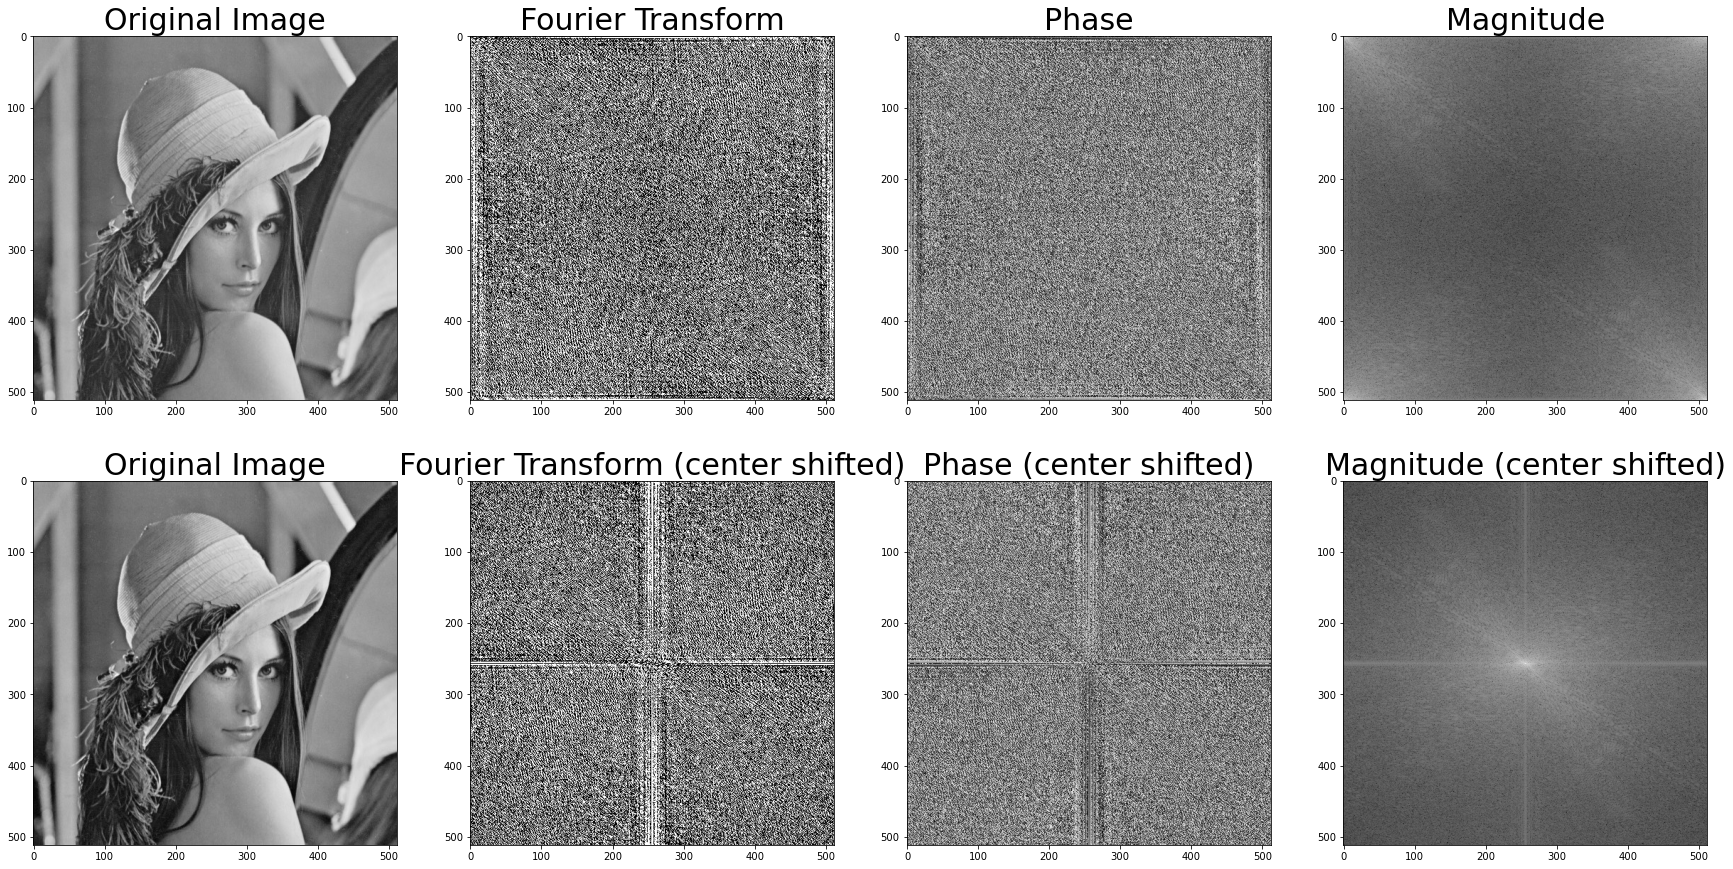

In [42]:

view_fourier(lena)

C:\Users\dhyut\AppData\Local\Temp/ipykernel_20076/2355633220.py:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols_FFT = np.asarray(rows_FFT, dtype=np.complex).T


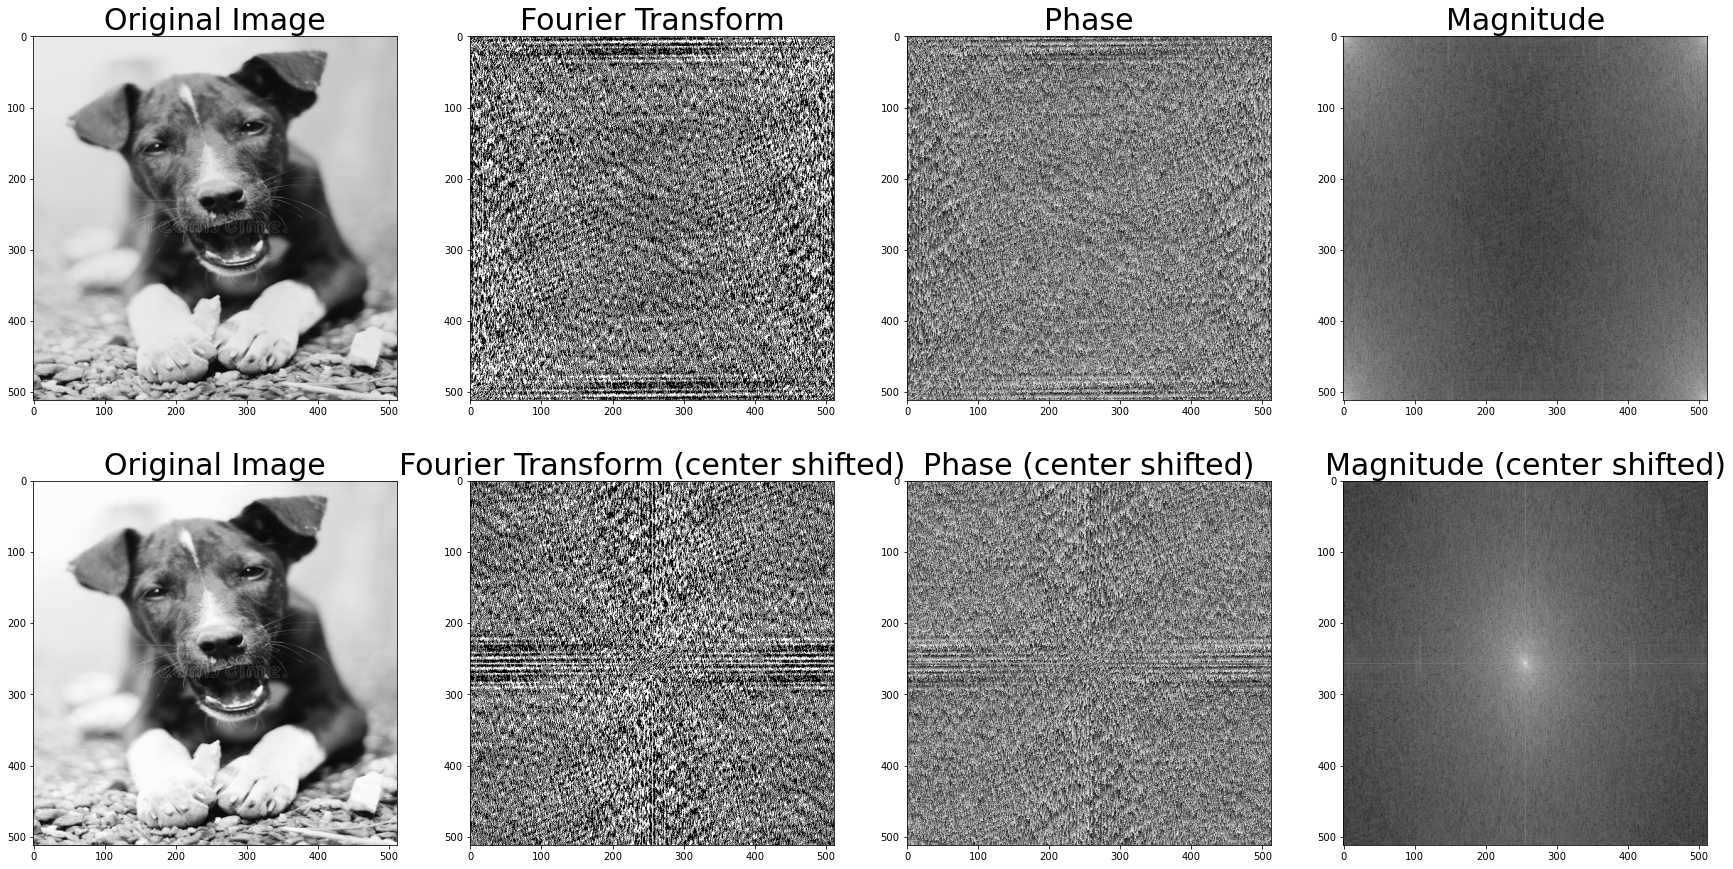

In [43]:
view_fourier(dog)

In [44]:
# Function to convert polar coordinates to rectangular coordinates
def rect_to_polar(magnitude, angle):
    return magnitude * np.exp(1j * angle)

# Vectorized function to convert polar coordinates to rectangular coordinates
rect_to_polar_vec = np.vectorize(rect_to_polar)

In [45]:
def IFFT_1D(signal):

    def worker(signal):
        n = len(signal)
        if n == 1:
            return signal

        w = np.power(np.e, 2 * np.pi * (1j) / n)
        signal_e = [signal[i] for i in range(len(signal)) if i%2 == 0]
        signal_o = [signal[i] for i in range(len(signal)) if i%2 == 1]

        SIGNAL = [0] * n
        SIGNAL_E = worker(signal_e)
        SIGNAL_O = worker(signal_o)

        n2 = round(n/2)
        for i in range(n2):
            SIGNAL[i] = SIGNAL_E[i] + np.power(w, i) * SIGNAL_O[i]
            SIGNAL[i+n2] = SIGNAL_E[i] - np.power(w, i) * SIGNAL_O[i]

        return SIGNAL
    return np.asarray(worker(signal)) / len(signal)

def IFFT_2D(img):
    rows_FFT = []
    for i in img:
        rows_FFT.append(IFFT_1D(i))
    
    cols_FFT = np.asarray(rows_FFT, dtype=np.complex).T
    IMG = []
    for i in cols_FFT:
        IMG.append(IFFT_1D(i))
    return np.asarray(IMG).T

C:\Users\dhyut\AppData\Local\Temp/ipykernel_20076/2355633220.py:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols_FFT = np.asarray(rows_FFT, dtype=np.complex).T
C:\Users\dhyut\AppData\Local\Temp/ipykernel_20076/2372151204.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols_FFT = np.asarray(rows_FFT, dtype=np.co

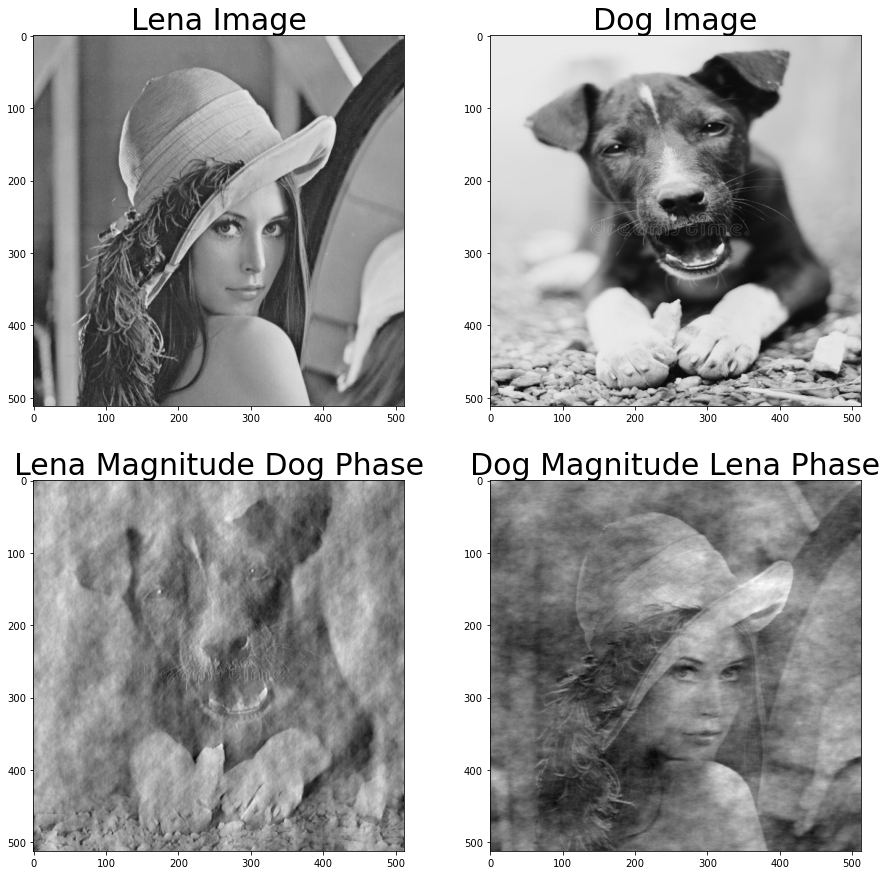

In [46]:
lena_FFT = FFT_2D(lena)
dog_FFT = FFT_2D(dog)

lena_magnitude = np.absolute(lena_FFT)
lena_phase = np.angle(lena_FFT)

dog_magnitude = np.absolute(dog_FFT)
dog_phase = np.angle(dog_FFT)

lena_mag_dog_phase_FFT = rect_to_polar_vec(lena_magnitude, dog_phase)
lena_mag_dog_phase = IFFT_2D(lena_mag_dog_phase_FFT)

dog_mag_lena_phase_FFT = rect_to_polar_vec(dog_magnitude, lena_phase)
dog_mag_lena_phase = IFFT_2D(dog_mag_lena_phase_FFT)

fig, elements=plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

elements[0,0].imshow(cv2.cvtColor(lena, cv2.COLOR_BGR2RGB))
elements[0,0].set_title("Lena Image", fontsize=30)
elements[0,1].imshow(cv2.cvtColor(dog, cv2.COLOR_BGR2RGB))
elements[0,1].set_title("Dog Image", fontsize=30)
elements[1,0].imshow(np.real(lena_mag_dog_phase), cmap='gray')
elements[1,0].set_title("Lena Magnitude Dog Phase", fontsize=30)
elements[1,1].imshow(np.real(dog_mag_lena_phase), cmap='gray')
elements[1,1].set_title("Dog Magnitude Lena Phase", fontsize=30)

plt.show()